In [102]:
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import tyro
from matplotlib.axes import Axes
from numpy.typing import NDArray
from shapely.geometry import Polygon

from mops.constants import figure_dir, logger
from mops.utils import dim_reduction, embedding, open_jsonl, save_fig

%config InlineBackend.figure_format = 'retina'

In [103]:
def _create_tsne_2d_embedding(
    premises: List[str],
    embedding_model: str = "all-MiniLM-L6-v2",
    tsne_random_state: int = 42,
) -> NDArray:
    sentence_embedding = embedding(premises, embedding_model)
    tsne_2d_embedding = dim_reduction(
        sentence_embedding, random_state=tsne_random_state
    )
    return tsne_2d_embedding

In [104]:
def breadth_metric(
    tsne_2d_embedding_dict: Dict[str, NDArray], axs: List[Axes], colors: List[str]
) -> List[Axes]:
    methods = tsne_2d_embedding_dict.keys()

    # Determine the scope of the plot:
    # the leftmost, rightmost, topmost, and bottommost
    # embedding 2d coordinates for all methods
    x_min, x_max = 100000, -100000
    y_min, y_max = 100000, -100000
    for method in methods:
        for x, y in tsne_2d_embedding_dict[method]:
            if x < x_min:
                x_min = x
            if x > x_max:
                x_max = x
            if y < y_min:
                y_min = y
            if y > y_max:
                y_max = y

    for idx, (method, ax) in enumerate(zip(methods, axs)):
        tsne_2d_embedding = tsne_2d_embedding_dict[method]
        color = colors[idx % len(colors)]

        ax.scatter(tsne_2d_embedding[:, 0], tsne_2d_embedding[:, 1], color=color, s=0.3)

        polygon = Polygon(tsne_2d_embedding)
        x_convex_hull, y_convex_hull = polygon.convex_hull.exterior.xy
        ax.plot(x_convex_hull, y_convex_hull, color=color)

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_title(
            f"{method} | breadth_score: {polygon.convex_hull.area:.3f} ↑",
            size="small",
        )
        logger.info(f"{method} | breadth_score: {polygon.convex_hull.area:.3f} ↑")

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

        ax.tick_params(axis="both", direction="in")
        ax.grid(visible=True, ls=":", zorder=0)

    return axs

In [105]:
def density_metric(
    tsne_2d_embedding_dict: Dict[str, NDArray],
    axs: List[Axes],
    color_maps: List[str],
    num_bins: int = 10
):

    methods = tsne_2d_embedding_dict.keys()
    
    # Determine the scope of the plot:
    # the leftmost, rightmost, topmost, and bottommost
    # embedding 2d coordinates for all methods
    x_min, x_max = 100000, -100000
    y_min, y_max = 100000, -100000
    for method in methods:
        for x, y in tsne_2d_embedding_dict[method]:
            if x < x_min:
                x_min = x
            if x > x_max:
                x_max = x
            if y < y_min:
                y_min = y
            if y > y_max:
                y_max = y

    extent = (x_min, x_max, y_min, y_max)

    for method, ax, cmap in zip(methods, axs, color_maps):

        # create a 2D histogram
        hist, xedges, yedges = np.histogram2d(
            tsne_2d_embedding_dict[method][:, 0],
            tsne_2d_embedding_dict[method][:, 1],
            bins=num_bins,
            range=[[x_min, x_max], [y_min, y_max]],
        )
        # invert the histogram matrix so that
        # rows represent y-coordinates and lists represent x-coordinates
        hist = hist.T 

        mask = np.ones_like(hist, dtype=bool)
        # iterate each row
        for i, row in enumerate(hist):
            # find the index of the first and last non-zero elements in each row
            non_zero_indices = np.where(row != 0)[0]
            if non_zero_indices.size > 0:
                first_non_zero = non_zero_indices[0]
                last_non_zero = non_zero_indices[-1]

                mask[i, first_non_zero : last_non_zero + 1] = False

        unmasked_elements = hist[~mask]
        unmasked_elements_list = unmasked_elements.tolist()
        density_score = np.std(unmasked_elements_list)
        logger.info(f"{method} | width_score: {density_score:.3f} ↓")

        bin_x = [(a + b) / 2 for a, b in zip(xedges[:-1], xedges[1:])]
        bin_y = [(a + b) / 2 for a, b in zip(yedges[:-1], yedges[1:])]
        for i, x in enumerate(bin_x):
            for j, y in enumerate(bin_y):
                if not mask[j, i]:
                    ax.annotate(
                        str(int(hist[j, i])),
                        xy=(x, y),
                        ha="center",
                        va="center",
                        color="black",
                    )
        ax.imshow(
            hist,
            origin="lower",
            extent=extent,
            aspect="auto",
            cmap=cmap,
        )
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)

        # traverse each element of the histogram and draw a diagonal(\) for blocks with a count of 0
        for i in range(len(yedges) - 1):
            for j in range(len(xedges) - 1):
                if mask[i, j]:
                    # calculate the center point of the block
                    center_x = (xedges[j] + xedges[j + 1]) / 2
                    center_y = (yedges[i] + yedges[i + 1]) / 2

                    # draw a diagonal line at the center of the block
                    ax.text(
                        center_x,
                        center_y,
                        "\\",
                        color="black",
                        ha="center",
                        va="center",
                    )

        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
        ax.set_title(f"{method} | density_score: {density_score:.2f} ↓", size="small")

    return axs

In [106]:
methods: List[str] = [
        "mops",
        "complex-gpt-3.5-turbo-1106",
        "vanilla-gpt-3.5-turbo-1106",
        "doc",
        "writingPrompts",
        "storium"
    ]

In [107]:
premise_paths: List[Path] = [
    Path("../assets/premises/mops/moderate.jsonl"),
    Path("../assets/premises/baselines/complex-gpt-3.5-turbo-1106.jsonl"),
    Path("../assets/premises/baselines/vanilla-gpt-3.5-turbo-1106.jsonl"),
    Path("../assets/premises/baselines/doc.jsonl"),
    Path("../assets/premises/baselines/writingPrompts.jsonl"),
    Path("../assets/premises/baselines/storium.jsonl")
]

In [108]:
embedding_dir: Path = Path("/tmp")
embedding_model: str = "all-MiniLM-L6-v2"  # "all-mpnet-base-v2" "all-MiniLM-L12-v2" "all-MiniLM-L6-v2"
tsne_random_state: int = 42

In [109]:
assert len(methods) == len(
    premise_paths
), f"""The num of methods and premises should be equal, 
    but found methods: {methods} and premises: {premise_paths}."""

In [110]:
colors = ["#D06464", "#8CB96E", "#5F94CF", "#745FB0", "#969696", "#F08705"]
tsne_2d_embedding_dict = dict()

for method, premise_path in zip(methods, premise_paths):
    embedding_path = embedding_dir / f"{method}_{embedding_model}_{tsne_random_state}.npy"

    premise_dicts = open_jsonl(premise_path)
    assert len(premise_dicts) > 0, f"No available premises found in {premise_path}"
    premises = [premise_dict["premise"] for premise_dict in premise_dicts]
    
    tsne_2d_embedding = _create_tsne_2d_embedding(premises, embedding_model, tsne_random_state)
    logger.info(f"Save tsne 2d embedding array in {embedding_path}.")
    np.save(embedding_path, tsne_2d_embedding)
    
    tsne_2d_embedding_dict[method] = tsne_2d_embedding

06-08 14:20:38 INFO     Save tsne 2d embedding array in /tmp/mops_all-MiniLM-L6-v2_42.npy.
06-08 14:20:39 INFO     Save tsne 2d embedding array in /tmp/complex-gpt-3.5-turbo-1106_all-MiniLM-L6-v2_42.npy.
06-08 14:20:41 INFO     Save tsne 2d embedding array in /tmp/vanilla-gpt-3.5-turbo-1106_all-MiniLM-L6-v2_42.npy.
06-08 14:20:43 INFO     Save tsne 2d embedding array in /tmp/doc_all-MiniLM-L6-v2_42.npy.
06-08 14:20:45 INFO     Save tsne 2d embedding array in /tmp/writingPrompts_all-MiniLM-L6-v2_42.npy.
06-08 14:20:49 INFO     Save tsne 2d embedding array in /tmp/storium_all-MiniLM-L6-v2_42.npy.


06-08 14:20:49 INFO     mops | breadth_score: 3545.783 ↑
06-08 14:20:49 INFO     complex-gpt-3.5-turbo-1106 | breadth_score: 2618.178 ↑
06-08 14:20:49 INFO     vanilla-gpt-3.5-turbo-1106 | breadth_score: 3050.722 ↑
06-08 14:20:49 INFO     doc | breadth_score: 1901.042 ↑
06-08 14:20:49 INFO     writingPrompts | breadth_score: 3013.612 ↑
06-08 14:20:50 INFO     storium | breadth_score: 1918.666 ↑
06-08 14:20:50 INFO     Save figure to: /data/code/acl_2024/mops/figures/breadth_all-MiniLM-L6-v2_42.pdf
06-08 14:20:50 INFO     Save figure to: /data/code/acl_2024/mops/figures/breadth_all-MiniLM-L6-v2_42.pdf


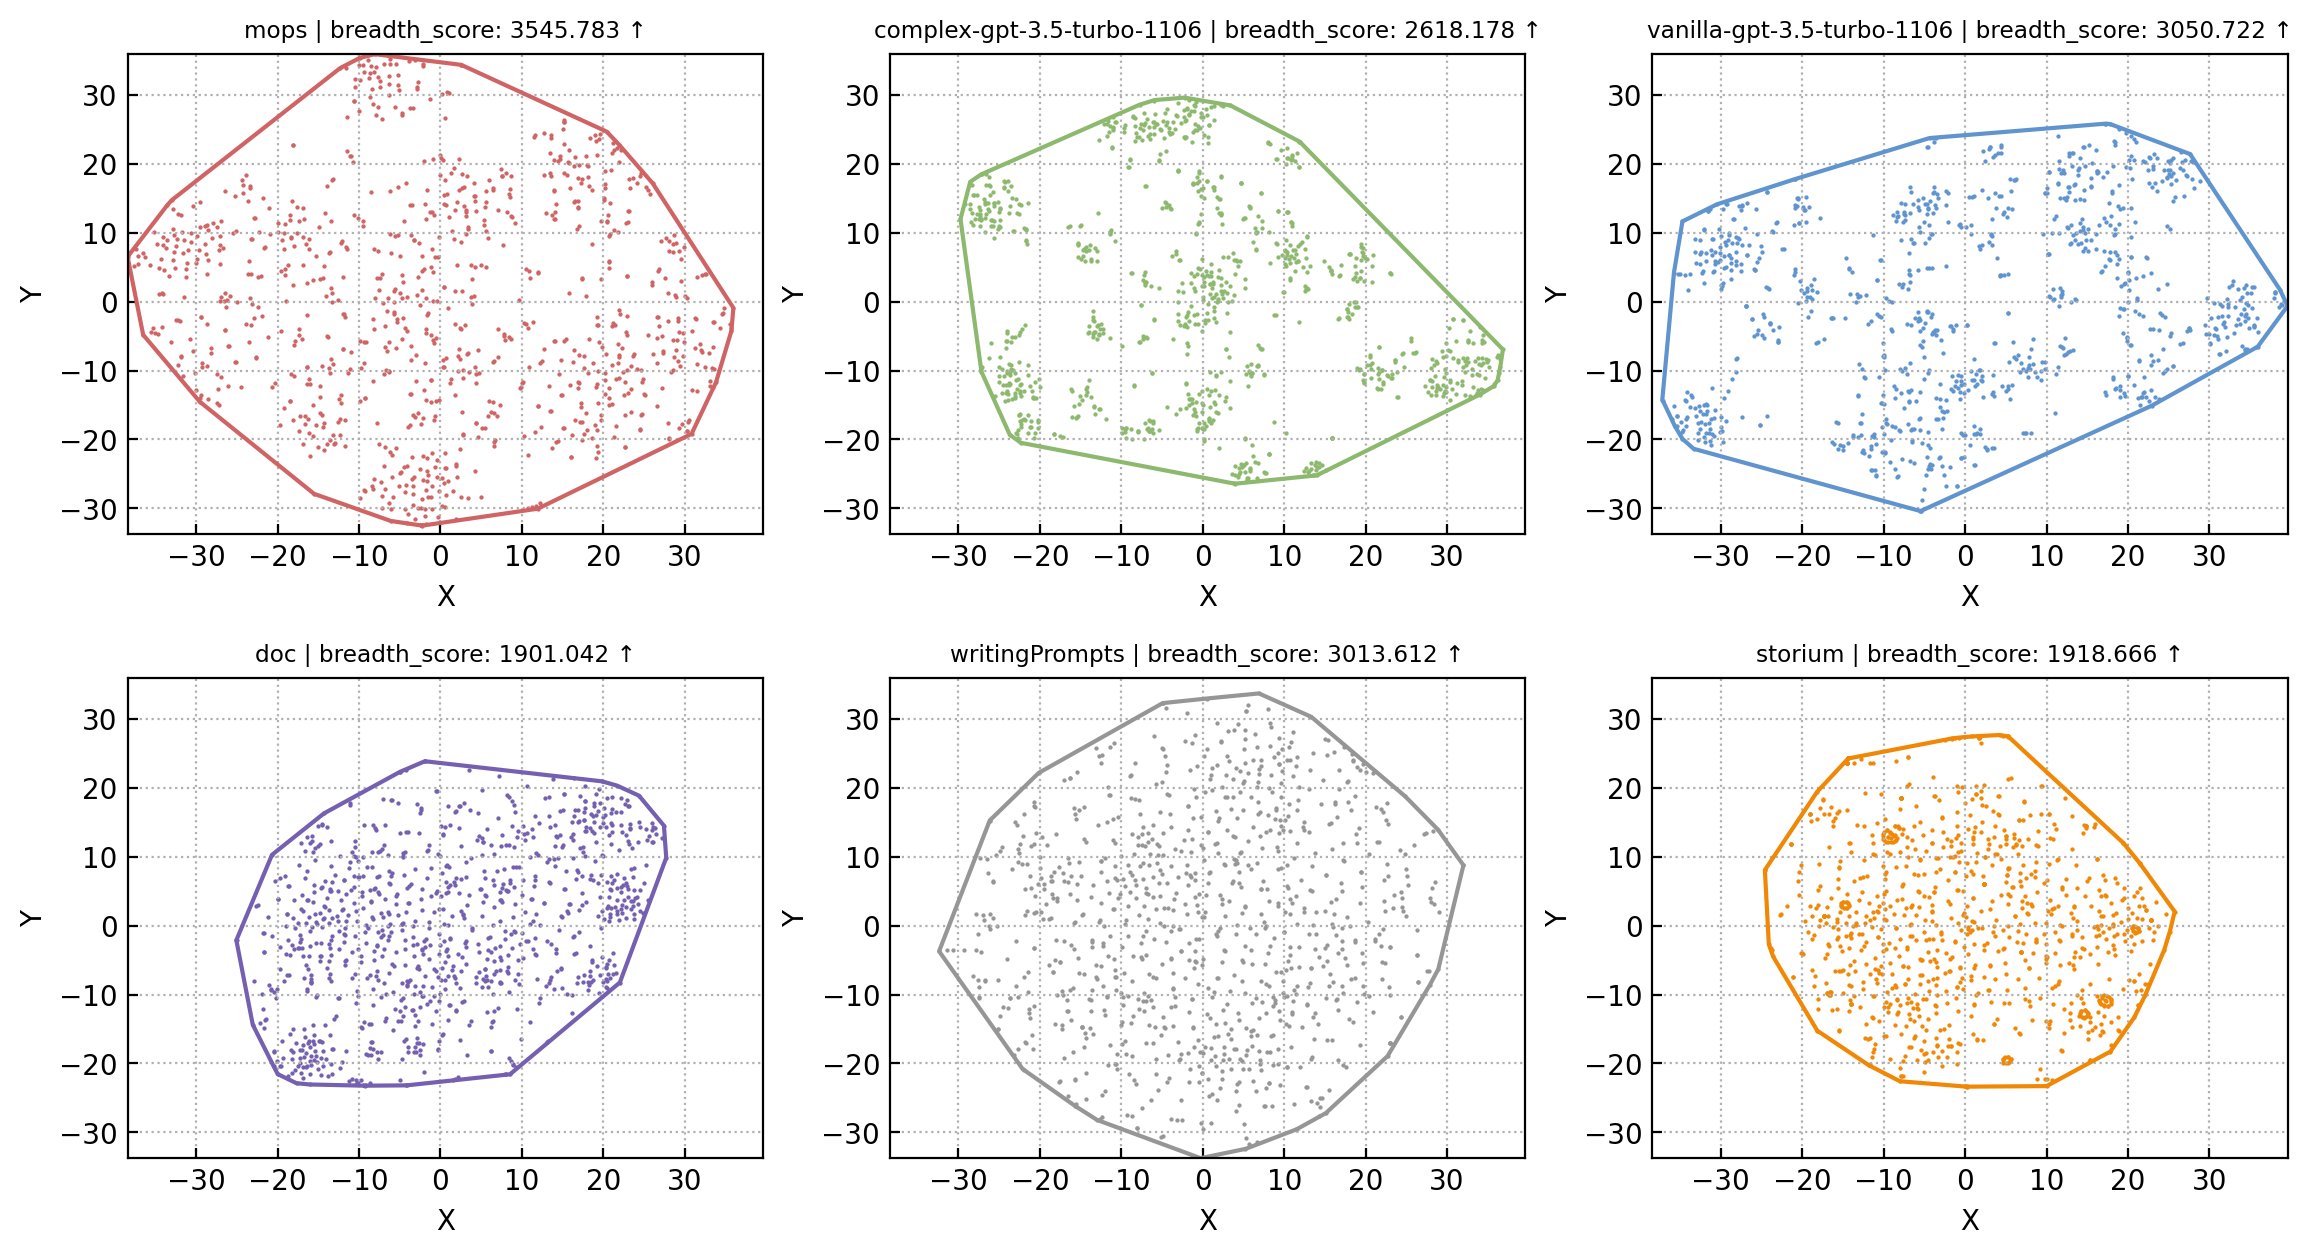

In [111]:
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96, wspace=0.2, hspace=0.3)
axs = axs.flatten().tolist()
axs = breadth_metric(tsne_2d_embedding_dict, axs, colors)
save_fig(
    fig,
    figure_dir / f"breadth_{embedding_model}_{tsne_random_state}.pdf",
    format="pdf",
    bbox_inches="tight",
)

06-08 14:20:51 INFO     mops | width_score: 7.522 ↓
06-08 14:20:51 INFO     complex-gpt-3.5-turbo-1106 | width_score: 14.629 ↓
06-08 14:20:51 INFO     vanilla-gpt-3.5-turbo-1106 | width_score: 11.081 ↓
06-08 14:20:51 INFO     doc | width_score: 14.220 ↓
06-08 14:20:51 INFO     writingPrompts | width_score: 8.532 ↓
06-08 14:20:51 INFO     storium | width_score: 13.818 ↓
06-08 14:20:51 INFO     Save figure to: /data/code/acl_2024/mops/figures/density_all-MiniLM-L6-v2_42.pdf
06-08 14:20:51 INFO     Save figure to: /data/code/acl_2024/mops/figures/density_all-MiniLM-L6-v2_42.pdf


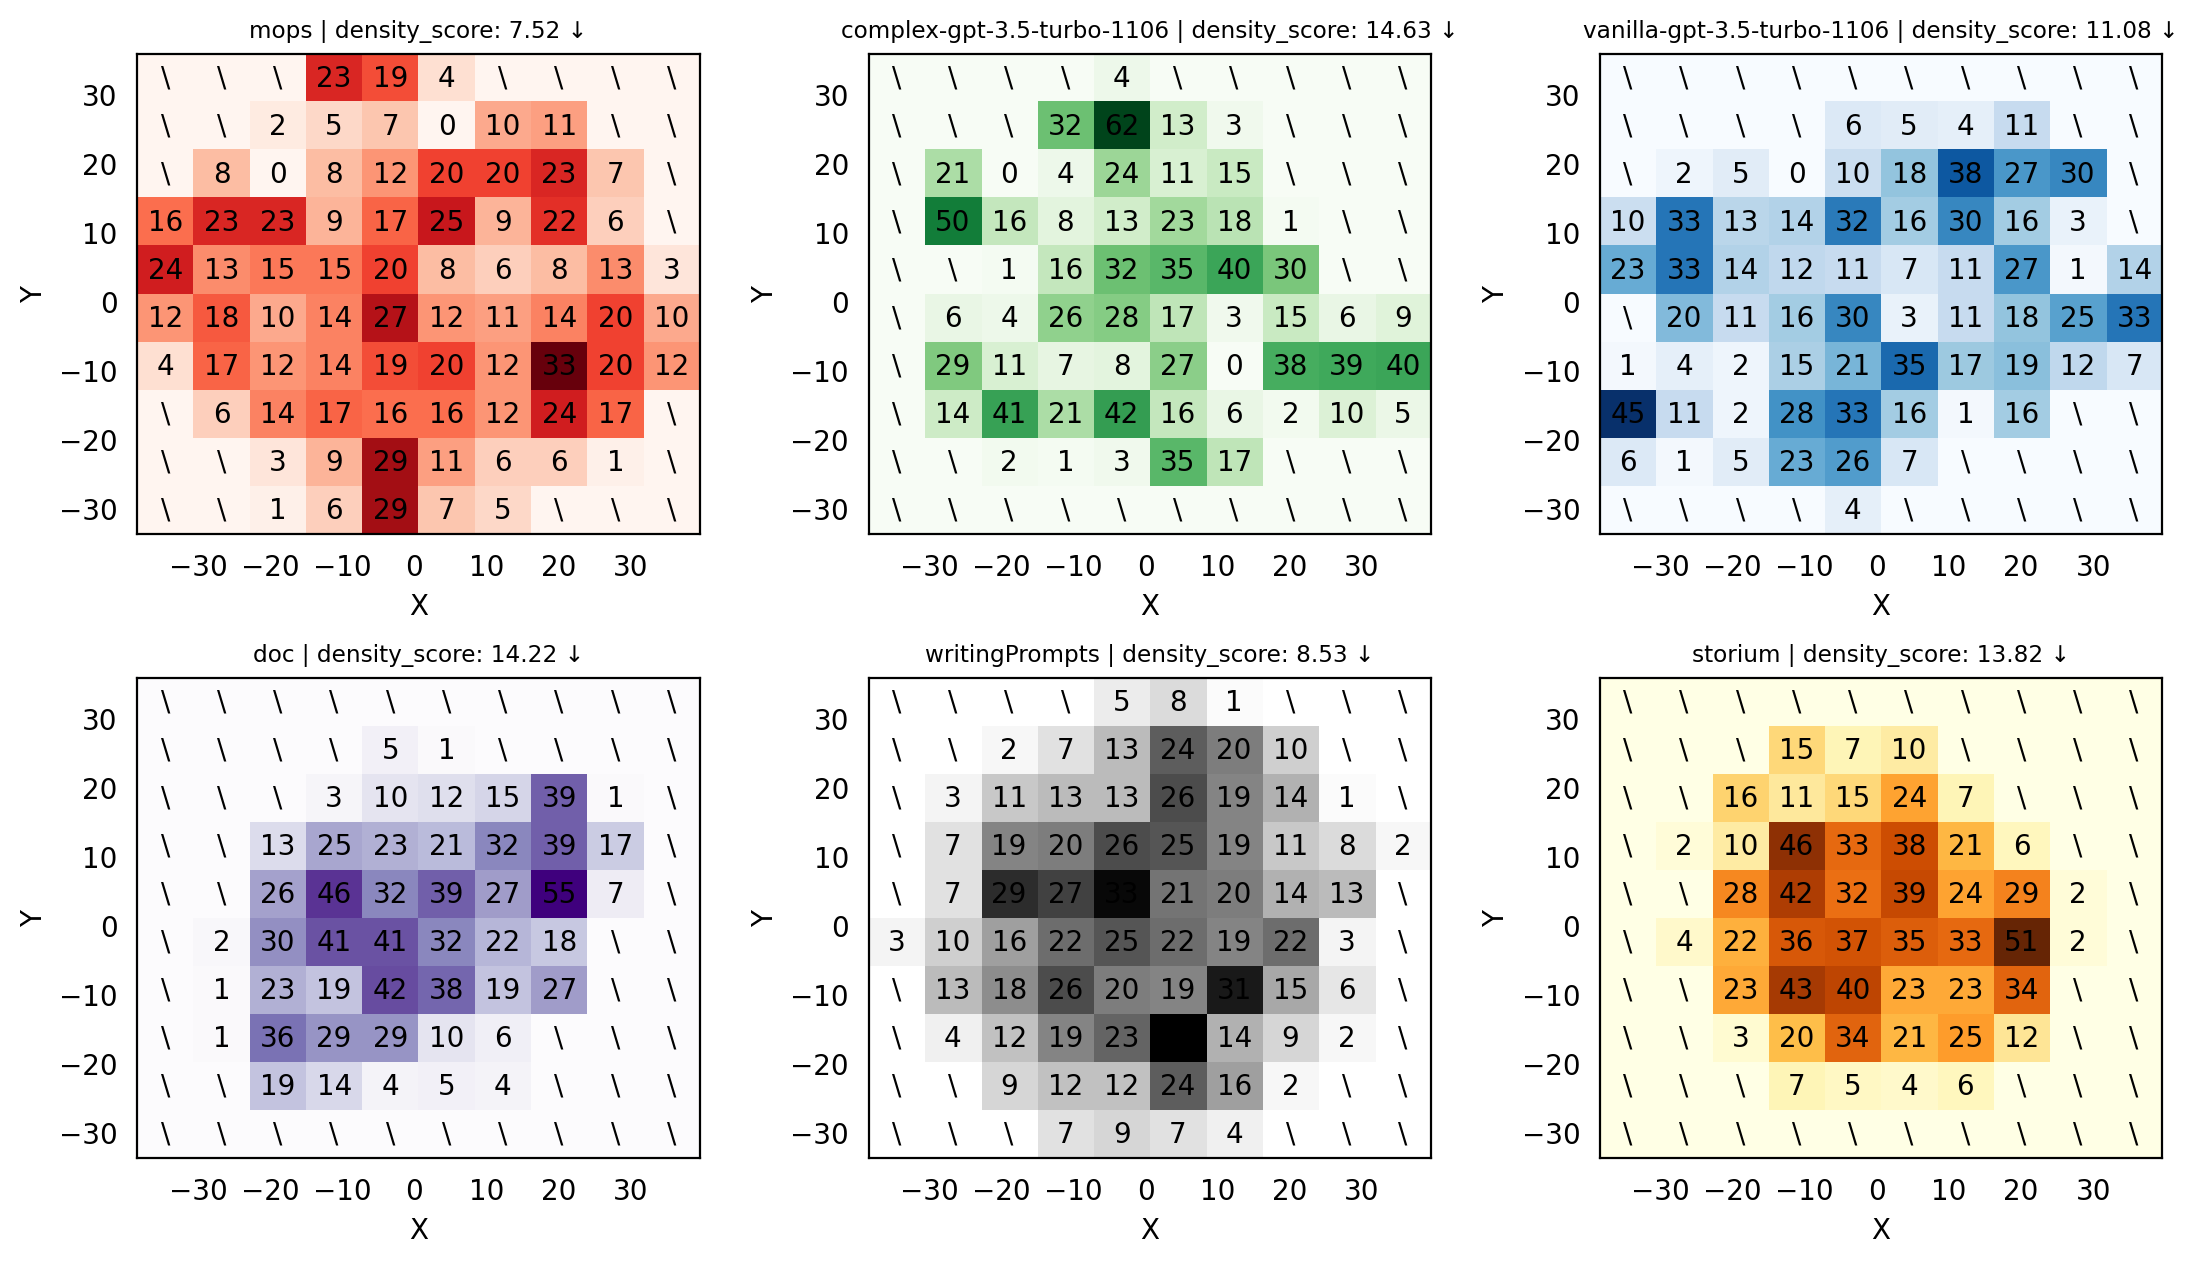

In [112]:
color_maps = [
    "Reds",
    "Greens",
    "Blues",
    "Purples",
    "Greys",
    "YlOrBr",
]
fig, axs = plt.subplots(2, 3, figsize=(3.75 * 3, 3 * 2))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.04, top=0.96, wspace=0.3, hspace=0.3)
axs = axs.flatten().tolist()
axs = density_metric(tsne_2d_embedding_dict, axs, color_maps, num_bins=10)
save_fig(
    fig,
    figure_dir / f"density_{embedding_model}_{tsne_random_state}.pdf",
    format="pdf",
    bbox_inches="tight",
)